# This notebook is to show that our analytical formula fits numerical data



In [3]:
######################################
## Imports and definitions
import numpy as np
import h5py as h5

from astropy.table import Table, Column
import astropy.units as u
from astropy import constants as const
from matplotlib import ticker, cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import matplotlib.pyplot as plt
import seaborn as sns

import MinimumMassFunctions as mfunc
import importlib
importlib.reload(mfunc)


######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


######################################
## locations
save_loc    =  '/n/home04/lvanson/LowMBH_peak/plots/'#'/Users/lieke/surfdrive/Documents/LowMBH_peak/plots/'#
proj_dir    = '/n/holystore01/LABS/hernquist_lab/Users/lvanson/CompasOutput/'#'/Users/lieke/surfdrive/Documents/LowMBH_peak/output/'#

data_dir    = proj_dir+'/v02.26.03/N1e6Grid_BBH_BHNS_optimized/'#v02.22.00/N1e5_grids/' N1e7_Fid/fWR1.0coolWind1.0/'

sim_save_str = ''

######################################
## Widescreen jupyter notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [4]:
q_crits = mfunc.get_qcrit_from_zeta(Beta = 1.0 , Zeta_eff = [3.5, 4.5, 5.5, 6.0,6.5]) 
print('first set of qcrits: ', q_crits[0], 'first mass transfer: ', q_crits[:,0], 'reverse mass transfer: ', q_crits[:,1])


for i in range(len([3.5, 4.5, 5.5, 6.0,6.5])):
    print(q_crits[i]) 


Zeta_eff is not a float
first set of qcrits:  [0.41371449 3.03320351] first mass transfer:  [0.41371449 0.3465735  0.29808706 0.2785703  0.26143655] reverse mass transfer:  [3.03320351 3.55051485 4.06444306 4.32045189 4.57594242]
[0.41371449 3.03320351]
[0.3465735  3.55051485]
[0.29808706 4.06444306]
[0.2785703  4.32045189]
[0.26143655 4.57594242]


# Let's load in the data from COMPAS

In [4]:

################################################
def hdf5_to_astropy(hdf5_file, group = 'BSE_System_Parameters' ):
    """convert your hdf5 table to astropy.table for easy indexing etc
    hdf5_file  =  Hdf5 file you would like to convert
    group      =  Data group that you want to acces
    """
    Data         = hdf5_file[group]#
    table = Table()
    for key in list(Data.keys()):
        table[key] =  Data[key]
    return table


#########################################
# Read data
#######################################
def read_data(loc = data_dir+'/output/COMPAS_Output_wWeights.h5', rate_key = 'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned', 
              verbose=False,sys_key = 'BSE_System_Parameters', dco_key = 'BSE_Double_Compact_Objects', rlof_key = 'BSE_RLOF'):
    """
        Read DCO, SYS and merger rate data, necesarry to make the plots in this 
        
        Args:
            loc                  --> [string] Location of data
            rate_key             --> [string] group key name of COMPAS HDF5 data that contains your merger rate
            verbose              --> [bool] If you want to print statements while reading in 

        Returns:
            crude_rate_density   --> [2D float array] Intrinsic merger rate density for each binary at new crude redshiftbins in 1/yr/Gpc^3

    """


    if verbose: print('Reading ',loc)
    ################################################
    ## Open hdf5 file
    File        = h5.File(loc ,'r')
    if verbose: print(File.keys(), File[rate_key].keys(), File[sys_key].keys(), File[dco_key].keys())
        
    

    ################################################
    ## Read merger rate related data
    DCO_mask                  = File[rate_key]['DCOmask'][()] # Mask from DCO to merging BBH 
    redshifts                 = File[rate_key]['redshifts'][()]
    Average_SF_mass_needed    = File[rate_key]['Average_SF_mass_needed'][()]
    intrinsic_rate_density    = File[rate_key]['merger_rate'][()]
    intrinsic_rate_density_z0 = File[rate_key]['merger_rate_z0'][()] #Rate density at z=0 for the smallest z bin in your simulation

    
    ################################################
    ## Get DCO info and pour into astropy table
    DCO         = Table()#hdf5_to_astropy(File, group = dco_key )  
    SYS         = Table()#hdf5_to_astropy(File, group = sys_key )  
    RLOF        = Table()#hdf5_to_astropy(File, group = rlof_key )  
    ################################################
    ## Add extra columns of interest to your DCO ##
    SYS_DCO_seeds_bool          = np.in1d(File[sys_key]['SEED'][()], File[dco_key]['SEED'][()]) #Bool to point SYS to DCO
    q_init                      = File[sys_key]['Mass@ZAMS(2)'][()]/File[sys_key]['Mass@ZAMS(1)'][()]
    DCO['SemiMajorAxis@ZAMS']   = File[sys_key]['SemiMajorAxis@ZAMS'][SYS_DCO_seeds_bool]
    DCO['Mass@ZAMS(1)']         = File[sys_key]['Mass@ZAMS(1)'][SYS_DCO_seeds_bool]
    DCO['Mass@ZAMS(2)']         = File[sys_key]['Mass@ZAMS(2)'][SYS_DCO_seeds_bool]
    try:
        DCO['CH_on_MS(1)']          = File[sys_key]['CH_on_MS(1)'][SYS_DCO_seeds_bool]
        DCO['CH_on_MS(2)']          = File[sys_key]['CH_on_MS(2)'][SYS_DCO_seeds_bool]
    except:
        print('no CH_on_MS')
    
    # Kick parameters (for debugging reproducability)
    DCO['SN_Kick_Magnitude_Random_Number(1)'] = File[sys_key]['SN_Kick_Magnitude_Random_Number(1)'][SYS_DCO_seeds_bool]
    DCO['SN_Kick_Magnitude_Random_Number(2)'] = File[sys_key]['SN_Kick_Magnitude_Random_Number(2)'][SYS_DCO_seeds_bool]
    DCO['Sigma_Kick_CCSN_BH']                   = File[sys_key]['Sigma_Kick_CCSN_BH'][SYS_DCO_seeds_bool]
    DCO['Sigma_Kick_CCSN_NS']                   = File[sys_key]['Sigma_Kick_CCSN_NS'][SYS_DCO_seeds_bool]
   
    DCO['SEED']                 = File[dco_key]['SEED'][()]
    DCO['mixture_weight']       = File[dco_key]['mixture_weight'][()]
    DCO['Metallicity@ZAMS(1)']  = File[dco_key]['Metallicity@ZAMS(1)'][()]
    DCO['Mass(1)']              = File[dco_key]['Mass(1)'][()]
    DCO['Mass(2)']              = File[dco_key]['Mass(2)'][()]
    DCO['Merges_Hubble_Time']   = File[dco_key]['Merges_Hubble_Time'][()]
    DCO['Coalescence_Time']     = File[dco_key]['Coalescence_Time'][()]
    DCO['Time']                 = File[dco_key]['Time'][()]
    try:
        DCO['CE_Event_Counter']     = File[dco_key]['CE_Event_Counter'][()]
    except:
        DCO['CE_Event_Counter']     = File[dco_key]['CE_Event_Count'][()]
    DCO['Stellar_Type(1)']      = File[dco_key]['Stellar_Type(1)'][()]
    DCO['Stellar_Type(2)']      = File[dco_key]['Stellar_Type(2)'][()]
    DCO['MT_Donor_Hist(1)']     = File[dco_key]['MT_Donor_Hist(1)'][()]
    DCO['MT_Donor_Hist(2)']     = File[dco_key]['MT_Donor_Hist(2)'][()]
    DCO['Optimistic_CE']        = File[dco_key]['Optimistic_CE'][()]
    DCO['Immediate_RLOF>CE']   = File[dco_key]['Immediate_RLOF>CE'][()]

    DCO['q_ZAMS']               = q_init[SYS_DCO_seeds_bool]
    DCO['Stellar_Type@ZAMS(1)'] = File[sys_key]['Stellar_Type@ZAMS(1)'][SYS_DCO_seeds_bool]
    DCO['Stellar_Type@ZAMS(2)'] = File[sys_key]['Stellar_Type@ZAMS(2)'][SYS_DCO_seeds_bool]
    DCO['tDelay']               = DCO['Coalescence_Time'] + DCO['Time'] #Myr    
    DCO['M_moreMassive']        = np.maximum(DCO['Mass(1)'], DCO['Mass(2)'])
    DCO['M_lessMassive']        = np.minimum(DCO['Mass(1)'], DCO['Mass(2)'])
    DCO['q_final']              = DCO['M_lessMassive']/DCO['M_moreMassive']
    DCO['m2_m1']                = DCO['Mass(2)']/DCO['Mass(1)']
    
    ############################
    # Add a bool for HG-HG donors
    firstMT_HG  =  np.array([DCO['MT_Donor_Hist(1)'][i][0] == '2' for i in range(len(DCO['MT_Donor_Hist(1)'])) ])
    secondMT_HG =  np.array([DCO['MT_Donor_Hist(2)'][i][0] == '2' for i in range(len(DCO['MT_Donor_Hist(2)'])) ])

    DCO['experiencedHGHG_MT'] = np.full(len(DCO), False)
    DCO['experiencedHGHG_MT'][firstMT_HG * secondMT_HG] = True

    ############################
    # Add a bool for case A donors
    firstMT_MS  =  np.array([DCO['MT_Donor_Hist(1)'][i][0] == '1' for i in range(len(DCO['MT_Donor_Hist(1)'])) ])
    DCO['first_MT_MS'] = np.full(len(DCO), False)
    DCO['first_MT_MS'][firstMT_MS] = True

    secondMT_MS =  np.array([DCO['MT_Donor_Hist(2)'][i][0] == '1' for i in range(len(DCO['MT_Donor_Hist(2)'])) ])
    DCO['second_MT_MS'] = np.full(len(DCO), False)
    DCO['second_MT_MS'][secondMT_MS] = True
    
    
    ############################
    # Add a bool for case A OR case B
    # i.e. securing that it experience some mass transfer both ways
    ############################
    DCO['caseAorB_MT'] = np.full(len(DCO), False)
    firstMT_caseAorB   = np.logical_or(firstMT_MS, firstMT_HG)
    secondMT_caseAorB  = np.logical_or(secondMT_MS, secondMT_HG)
    DCO['caseAorB_MT'][firstMT_caseAorB * secondMT_caseAorB ] = True
    
    #RLOF
    RLOF['SEED']              = File[rlof_key]['SEED'][()]
    RLOF['CEE>MT']            = File[rlof_key]['CEE>MT'][()]
    RLOF['MT_Event_Counter']  = File[rlof_key]['MT_Event_Counter'][()]
    RLOF['RLOF(1)>MT']        = File[rlof_key]['RLOF(1)>MT'][()]
    RLOF['RLOF(2)>MT']        = File[rlof_key]['RLOF(2)>MT'][()]
    RLOF['Mass(1)<MT']        = File[rlof_key]['Mass(1)<MT'][()]
    RLOF['Mass(1)>MT']        = File[rlof_key]['Mass(1)>MT'][()]
    RLOF['Mass(2)<MT']        = File[rlof_key]['Mass(2)<MT'][()]
    RLOF['Mass(2)>MT']        = File[rlof_key]['Mass(2)>MT'][()]
    RLOF['Eccentricity<MT']   = File[rlof_key]['Eccentricity<MT'][()]
    RLOF['Eccentricity>MT']   = File[rlof_key]['Eccentricity>MT'][()]
    
    ################################################
    
    File.close()
    
    return RLOF, SYS, DCO, DCO_mask, redshifts, Average_SF_mass_needed, intrinsic_rate_density, intrinsic_rate_density_z0 

    


In [5]:


def get_only_stableDCO(File_location = data_dir+'beta1.0'+'/output/COMPAS_Output_wWeights.h5', 
                       Rate_key      =  'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned',
                       DCO_type = "BBH_only", verbose = False,
                       sys_key = 'BSE_System_Parameters', dco_key = 'BSE_Double_Compact_Objects', rlof_key = 'BSE_RLOF'):
    
    ####################################################
    ### ## Reading file ##
    print(File_location)
    RLOF, SYS, DCO, DCO_mask, redshifts, Average_SF_mass_needed, intrinsic_rate_density, intrinsic_rate_density_z0, = read_data(loc = File_location, rate_key = Rate_key,
                                                                                                                               sys_key = sys_key, dco_key = dco_key, rlof_key = rlof_key)
    
    ####################################################
    # Select for either BBH, or for BH + BHNS
    try:
        noCHE_bool            = np.logical_and(DCO['CH_on_MS(1)'] ==False, DCO['CH_on_MS(2)'] ==False) #Remove CHE systems
    except:
        noCHE_bool        = np.logical_and(DCO['Stellar_Type@ZAMS(1)'] != 16, DCO['Stellar_Type@ZAMS(2)'] != 16)
    
    BBH_bool  = np.logical_and(DCO['Stellar_Type(1)'] == 14, DCO['Stellar_Type(2)'] == 14)
    BHNS_bool = np.logical_or(np.logical_and(DCO['Stellar_Type(1)'] == 13, DCO['Stellar_Type(2)'] == 14),
                                  np.logical_and(DCO['Stellar_Type(1)'] == 14, DCO['Stellar_Type(2)'] == 13))
    if DCO_type == "BBH_only":
        DCO_mask = BBH_bool * DCO_mask
    
    # You want both BBH and BHNS
    elif DCO_type == "BBH_BHNS":

        BBH_BHNS       = np.logical_or(BBH_bool, BHNS_bool)
        pessimistic_CE = DCO['Optimistic_CE'] == False
        immediateRLOF  = DCO['Immediate_RLOF>CE'] == False
        
        #Change DCO mask to fit your needs
        DCO_mask = BBH_BHNS * pessimistic_CE * immediateRLOF * DCO_mask
        
    else:
        print('ERROR, please select either DCO_type = "BBH_only" or "BBH_BHNS", you provided: %s'%(DCO_type))
        return
        
    merging_BH       = DCO[DCO_mask* noCHE_bool ] 
    
    ####################################################
    # OK now we want to select all the merging BBHs that evolve through the stable channel:
    MergingBBH_stable = merging_BH[merging_BH['CE_Event_Counter'] == 0]

    minBHmass_seed = merging_BH['SEED'][merging_BH['Mass(1)'] == min(merging_BH['Mass(1)']) ]
    if verbose: print('Min merging BH mass 1', min(merging_BH['Mass(1)']))
    if verbose: print('Min merging BH mass 2', min(merging_BH['Mass(2)']))
    # Now we want to get all the info from the RLOF table and append it to the MergingBBH_stable table
    # Lets start by selecting all seeds in RLOF that occur in MergingBBH_stable
    RLOF_stableBBH_seeds_bool          = np.in1d(RLOF['SEED'], MergingBBH_stable['SEED']) #Bool to point RLOF to merging BBH
    stableBBH_RLOF_events              = RLOF[RLOF_stableBBH_seeds_bool]


    # Just checking that there are no CE in this table
    if verbose: print((stableBBH_RLOF_events['CEE>MT'].any == True) )

    ########################################
    #First mass transfer
    # Grab all mass transfer events where it is the first mass transfer, and star 1 is RLOF
    first_MT = np.logical_and(stableBBH_RLOF_events['MT_Event_Counter'] == 1, stableBBH_RLOF_events['RLOF(1)>MT'] == 1)
    first_MT_table = stableBBH_RLOF_events[first_MT]

    ########################################
    # Second mass transfer
    second_MT = np.logical_and(stableBBH_RLOF_events['MT_Event_Counter'] == 2, stableBBH_RLOF_events['RLOF(2)>MT'] == 1)
    second_MT_table = stableBBH_RLOF_events[second_MT]
    
    ########################################
    # Lets first focus on the "normal" ones, before we dive into the outliers
    first_MT_seed  = stableBBH_RLOF_events['SEED'][first_MT]
    second_MT_seed = stableBBH_RLOF_events['SEED'][second_MT]
    if verbose: print('len(first_MT_seed)', len(first_MT_seed), 'len(second_MT_seed)', len(second_MT_seed))
    
    # Find the seeds that happen in both arrays
    overlapping_seeds12, mt1_ind, mt2_ind = np.intersect1d(first_MT_seed, second_MT_seed, return_indices=True)
    # reduce both arrays to only include systems which experience both MT 1 and MT 2
    first_MT_seed  = first_MT_seed[mt1_ind]
    second_MT_seed = second_MT_seed[mt2_ind]
    
    ########################################
    # Now select all the tables for MT1, MT2 and the DCO table
    BBH_MT2_seeds_bool          = np.in1d(MergingBBH_stable['SEED'], second_MT_seed) #Bool to point MergingBBH_stable to MT2
    Final_DCO                   = MergingBBH_stable[BBH_MT2_seeds_bool]

    MT1_MT2_seeds_bool          = np.in1d(first_MT_table['SEED'], second_MT_seed) #Bool to point MT1 to MT2
    final_firstMT               = first_MT_table[MT1_MT2_seeds_bool]

    MT2_MT2reduced_seeds_bool   = np.in1d(second_MT_table['SEED'], second_MT_seed) #Bool to point MT1 to MT2
    final_secondMT              = second_MT_table[MT2_MT2reduced_seeds_bool]

    # Lets check if they are all in order:
    if verbose: print('Final_DCO', len(Final_DCO['SEED']), 'final_firstMT', len(final_firstMT['SEED']), 'final_secondMT', len(final_secondMT['SEED']))
    print('should be empty:', np.nonzero(Final_DCO['SEED']- final_firstMT['SEED']), np.nonzero(Final_DCO['SEED'] - final_secondMT['SEED']) )

    for key in final_firstMT.keys():
        Final_DCO['first_MT_' + key] = final_firstMT[key]
        Final_DCO['second_MT_' + key] = final_secondMT[key]

    ##############################
    # Add a whole bunch of useful parameters
#     Final_DCO['logSemiMajorAxis@ZAMS_inRsun'] = np.log10(Final_DCO['SemiMajorAxis@ZAMS'] * u.AU.to(u.Rsun))
    Final_DCO['logMetallicity@ZAMS(1)']   = np.log10(Final_DCO['Metallicity@ZAMS(1)'] )
    M_donated                             = Final_DCO['first_MT_Mass(1)<MT'] - Final_DCO['first_MT_Mass(1)>MT']
    M_accreted                            = Final_DCO['first_MT_Mass(2)>MT'] - Final_DCO['first_MT_Mass(2)<MT'] 
    Final_DCO['beta']                     = M_accreted/M_donated
    Final_DCO['fcore1']                   = Final_DCO['first_MT_Mass(1)>MT']/Final_DCO['Mass@ZAMS(1)'] #Mcore1 - MBH1
    Final_DCO['fcore2']                   = Final_DCO['second_MT_Mass(2)>MT']/Final_DCO['second_MT_Mass(2)<MT'] #Mcore1 - MBH1
    Final_DCO['dMsn1']                    = Final_DCO['first_MT_Mass(1)>MT'] - Final_DCO['Mass(1)'] #Mcore1 - MBH1
    Final_DCO['dMsn2']                    = Final_DCO['second_MT_Mass(2)>MT'] - Final_DCO['Mass(2)'] #Mcore2 - MBH2
    Final_DCO['dMsn1_dMzams']             = Final_DCO['dMsn1']/Final_DCO['Mass@ZAMS(1)']
    Final_DCO['q_bh2bh1']                 = Final_DCO['Mass(2)']/Final_DCO['Mass(1)']
    Final_DCO['q_<MT2']                   = Final_DCO['second_MT_Mass(2)<MT']/Final_DCO['second_MT_Mass(1)<MT']
    Final_DCO['q_<MT2_inv']               = Final_DCO['second_MT_Mass(1)<MT']/Final_DCO['second_MT_Mass(2)<MT']
    Final_DCO['q_<MT1']                   = Final_DCO['first_MT_Mass(2)<MT']/Final_DCO['first_MT_Mass(1)<MT']
    Final_DCO['fc2_fc1']                = Final_DCO['fcore2'] / Final_DCO['fcore1'] 
    if verbose: print('Maximum mass ratio pre MT 2 = ', max(Final_DCO['q_<MT2']))

    return Final_DCO, merging_BH, DCO


In [6]:
# simname    = 'faccFIXEDbeta0.5zetaHG3.5RemMassFRYER2012SNDELAYED'
# # 'faccFIXEDbeta1.0zetaHG6.0RemMassFRYER2012SNDELAYED'#'faccFIXEDbeta1.0'# 

# ####################################################
# ### READ DCO
# Rate_key      =  'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned'
# RLOF, SYS, DCO, DCO_mask, redshifts, Average_SF_mass_needed, intrinsic_rate_density, intrinsic_rate_density_z0, =\
#     read_data(loc =  proj_dir+'/v02.26.03/N1e6Grid_BBH_BHNS_optimized/'+ simname+ '/output/COMPAS_Output_wWeights.h5', rate_key = Rate_key, verbose = False)


# ####################################################
# ### READ Only stable 
# Final_DCO, merging_BH, DCO = get_only_stableDCO(File_location = proj_dir+'/v02.26.03/N1e6Grid_BBH_BHNS_optimized/'+ simname +'/output/COMPAS_Output_wWeights.h5', 
#                                                 DCO_type = "BBH_BHNS")#BBH_only




# Minimum BH masses

We derive the minimum BH mass 1 and 2 in "[Derivation_minMBH_stable_channel](Derivation_minMBH_stable_channel)", here we will use that derivation to plot the analytically expected minimum BH masses for different variations 

Here we are just going to import them directly from MinimumMassFunctions.py



In [7]:
import MinimumMassFunctions as mfunc
import importlib
importlib.reload(mfunc)


<module 'MinimumMassFunctions' from '/n/home04/lvanson/LowMBH_peak/Code/MinimumMassFunctions.py'>

# Now let's plot our ZAMS mass ratios against MBH

# Method (A) for dMsn = f(M) and fcore = constant


In [8]:

##########################
# Start plotting
##########################
def plot_MZAMS_QZAMS(qzams, MBH1_list, MBH2_list, MZAMS_list, simnames, simdir = proj_dir+'/v02.26.03/N1e6Grid_BBH_BHNS_optimized/',
                     scatter_compas = False, percentile_compas = False,show_analytical_sol = True,
                     var_name = r'$\beta_{acc}$', var_list = None, title_text = '', 
                     x_key = 'q_ZAMS', y_key = 'Mass@ZAMS(1)', ylabel= r'$\mathrm{More \ massive \ component}, \  M_{\mathrm{primary}} \ \rm [M_{\odot}]$',
                     y_lim = (0.,150.), colors = ['#051126', '#4c3f77', '#7c587f', '#a4bcbc', '#007f97'],
                     save_name = 'MinimumComparedToSim.png',title_string='$\mathrm{Mass \ dependent \ SN mass \ loss}$'):

    ##########################
    fig,ax = plt.subplots(figsize = (12,10))
    plot_lines = []
    
    ##########################   
    for i, simname in enumerate(simnames):
        print(i)
        if show_analytical_sol: 
            ##################################################
            # Plot analytical solutions
            ##########################
            Min_MBH1 = MBH1_list[i]
            minM_BH2 = MBH2_list[i]

            if y_key == 'Mass@ZAMS(1)':
                plot_lines.append(plt.plot(qzams, MZAMS_list[i], c = colors[i], ls = ':', lw = 5, label = '$\min(M_{zams1})$ stable MT2'))

            if y_key == 'Mass(1)':
                print('qzams, Min_MBH1', qzams, Min_MBH1)
                plt.plot(qzams, Min_MBH1, c = colors[i], ls = '-', lw = 5, label = '$\mathrm{Analytical \ } \min(M_{BH1})$')

            if y_key == 'Mass(2)':
                plt.plot(qzams, minM_BH2, c = colors[i], ls = '--', lw = 5, label = '$\mathrm{Analytical \ } \min(M_{BH2})$ ')

            if y_key =='M_moreMassive':
                M1_morethan_M2 = Min_MBH1 >= minM_BH2
                plot_lines.append(plt.plot(qzams[M1_morethan_M2], Min_MBH1[M1_morethan_M2], c = colors[i], ls = '-', lw = 5, label = '$\mathrm{Analytical \ } \min(M_{BH,1})$ '))
                plt.plot(qzams[np.invert(M1_morethan_M2)], minM_BH2[np.invert(M1_morethan_M2)], c = colors[i], ls = '--', lw = 5, label = '$\mathrm{Analytical \ } \min(M_{BH,2})$ ')

        ##################################################
        # Plot numerical (COMPAS)
        ##########################
        if np.logical_or(scatter_compas,percentile_compas):
            print('reading in ', simname)
            try:
                Rate_key      =  'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05' + '_a0.02_b1.48_c4.45_d5.9' + '_zBinned'     # High resolution data has the full key name (also specifying SFRD(z))
                RLOF, SYS, DCO, DCO_mask, redshifts, Average_SF_mass_needed, intrinsic_rate_density, intrinsic_rate_density_z0, =\
                    read_data(loc = simdir + simname+ '/output/COMPAS_Output_wWeights.h5', rate_key = Rate_key, verbose = False)
            except:
                Rate_key      =  'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05' + '_zBinned'                                 # low resolution data has a different key name (not specifying SFRD(z))
                RLOF, SYS, DCO, DCO_mask, redshifts, Average_SF_mass_needed, intrinsic_rate_density, intrinsic_rate_density_z0, =\
                    read_data(loc = simdir + simname+ '/output/COMPAS_Output_wWeights.h5', rate_key = Rate_key, verbose = False)

            ##########################
            # Filter out XX
            plot_table  = DCO 
            stable_RLOF = plot_table['CE_Event_Counter'] == 0 #CE_Event_Counter
            not_CHE     = DCO['Stellar_Type@ZAMS(1)'] != 16
            #no_NSNS     = np.invert(np.logical_and(plot_table['Stellar_Type(1)'] ==13, plot_table['Stellar_Type(2)'] == 13))
            #merge_bool = plot_table['Merges_Hubble_Time']==True 
            #extra_bool  = plot_table['experiencedHGHG_MT'] == True
            extra_bool  = plot_table['caseAorB_MT'] == True
            
            # stable RLOF channel
            BBH_stablechannel     = plot_table[stable_RLOF * not_CHE * extra_bool]
    
            ##########################
            if scatter_compas:
                print('LEN ', len(BBH_stablechannel[x_key]))
                plt.scatter(BBH_stablechannel[x_key], BBH_stablechannel[y_key],
                            s = 50* BBH_stablechannel['mixture_weight'], c = 'grey', label =None, marker = 'o')#    
            if percentile_compas:
                dx = 0.02
                x_bins, min_array = np.arange(min(BBH_stablechannel[x_key]),max(BBH_stablechannel[x_key])+dx,dx), []
                center_x = (x_bins[:-1] + x_bins[1:])/2. 

                # Bin the data
                BinnedIndices = np.digitize(BBH_stablechannel[x_key],  x_bins)
                for BIN in range(len(center_x)):#np.unique(BinnedIndices):
                    bin_bool = BinnedIndices == BIN # grab systems in this bin
                    # calculate where 97% is higher (1-percentile?)
                    DATA = BBH_stablechannel[y_key][bin_bool]
                    if len(DATA) > 25:
                        percentile = mfunc.weighted_percentile(data = DATA, weights = BBH_stablechannel['mixture_weight'][bin_bool], perc = 0.01)
                    else:
                        print('percentile failed, too little data in bin: ', sum(bin_bool), sum(BBH_stablechannel['mixture_weight'][bin_bool]))
                        percentile = -1
                    min_array.append(percentile)
                ##########################
                # Plot it
                plt.plot(center_x, min_array, marker='^', markevery=2,linestyle = 'None',
                         markerfacecolor='None', markeredgecolor=colors[i],markeredgewidth = 3,
                            label ='$\mathrm{Numerical \ } 99.\% > x$', markersize = 10, zorder = 10)

        ########################## 
        # Plot first legend
        if i ==0:
            legend1 = plt.legend(loc = 'upper left')
            
    ##########################        
    # NS boundary
    plt.axhline(y = 2.5, lw = 3, color = 'grey', ls = '--')
#     ax.fill_between(np.arange(0,1.2,0.1), y1=0, y2 = 2.5, lw = 3, color = 'none', hatch= '//', edgecolor='grey')
    ax.text(0.5, 1, 'NS formation', fontsize = 20, ha = 'center', va = 'center', color = 'k', clip_on = True)
         

    #####
    # add legend
    leg = plt.legend([l[0] for l in plot_lines], var_list,#['$%s$'%(v) for v in var_list ], 
               title = var_name, loc = 'center left')
    leg._legend_box.align = "right"
    plt.gca().add_artist(legend1)
    
    #and Title
    ax.set_title(title_text,  x=0.05, y=1. , ha = 'left')
    
    ##########################
    # Plotvalues 
    plt.xlabel('$q_{\mathrm{ZAMS}} \equiv M_{\mathrm{ZAMS,b}}/M_{\mathrm{ZAMS,a}} $', size =35)#x_key.replace('_', ' '))
    plt.ylabel(ylabel, size =35)#y_key.replace('_', ' '))

    plt.grid()
    plt.xlim(0.,1.0)
    plt.ylim(y_lim)
    plt.savefig(save_loc + save_name)
    plt.show()



    

# fcore variations

both beta and zeta are floats
using method A, fc = const, dMsn(M)
using predefined MBH1 and qcrits
using method A, fc = const, dMsn(M)
using predefined MBH1 and qcrits
using method A, fc = const, dMsn(M)
using predefined MBH1 and qcrits
using method A, fc = const, dMsn(M)
using predefined MBH1 and qcrits
using method A, fc = const, dMsn(M)
using predefined MBH1 and qcrits
0
reading in  faccFIXEDbeta0.5fcore0.8zetaHG6.0RemMassFRYER2012SNDELAYED
percentile failed, too little data in bin:  0 0
percentile failed, too little data in bin:  4 7.920792079207921
percentile failed, too little data in bin:  5 9.900990099009876
percentile failed, too little data in bin:  13 0.8385698800451454
percentile failed, too little data in bin:  18 0.8768020535139996
percentile failed, too little data in bin:  16 0.34348444886201307
percentile failed, too little data in bin:  5 0.12555274535139643
percentile failed, too little data in bin:  1 0.00583347317971632
1
reading in  faccFIXEDbeta0.5fcore0.9zetaHG6

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


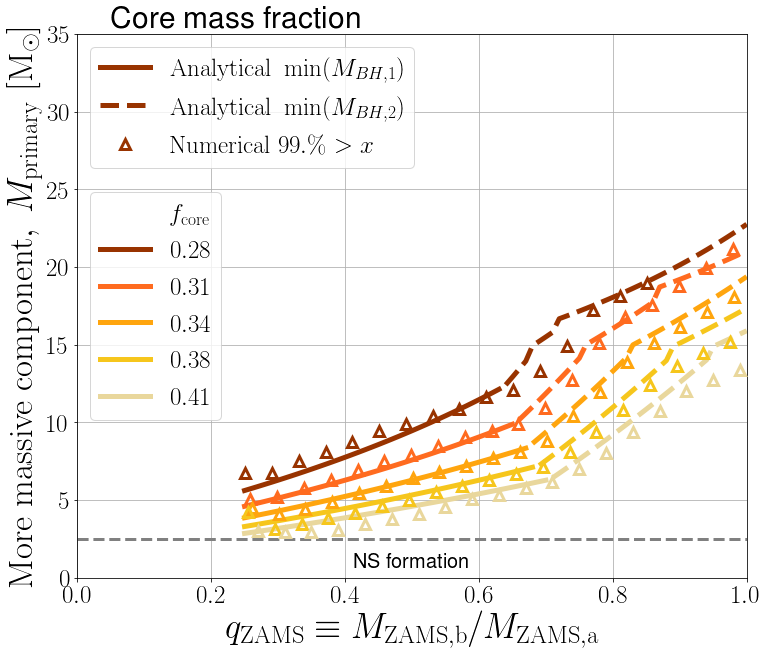

In [9]:
##########################
# Define the variables
##########################
qzams       = np.arange(0.25,1.01, 0.01)
zeta        = 5.5
q_crits     = mfunc.get_qcrit_from_zeta(Beta = 0.5, Zeta_eff = zeta)
qcrit2      = 4.06
use_zeta    = False

use_dMsn    = True
A_sn        = -0.9
B_sn        = 13.9
M_threshold = 14.8

xcore_list  = [0.8, 0.9, 1.0, 1.1, 1.2]
Fc1_list    = [0.345*xcore for xcore in xcore_list] #[0.8*0.34, 0.34, 1.2*0.34 ]#[0.30, 0.34, 0.38, 0.42 ]

beta = 0.5

# Simnames
simnames = ['faccFIXEDbeta0.5fcore%szetaHG6.0RemMassFRYER2012SNDELAYED'%(xcore) for xcore in xcore_list  ]

##########################
# Get minimum Mbh1,2 and ZAMS
##########################
MBH1_list, MBH2_list, MZAMS_list = [],[],[]


for Fc1 in Fc1_list:

    # Mbh1
    Min_MBH1, qcrits = mfunc.get_analyticalMBH1(use_zeta = use_zeta, zeta = zeta, qcrit1 = qzams, qcrit2 = qcrit2, 
                                                Fc1 = Fc1, M_threshold = M_threshold,Beta = beta, verbose = False,
                                                use_dMsn = use_dMsn, A_sn = A_sn, B_sn = B_sn)
    MBH1_list.append(Min_MBH1)

    # Mbh2
    minM_BH2 = mfunc.get_analyticalMBH2(minM_BH1 = Min_MBH1, qcrits = qcrits, Fc2 = Fc1)
    MBH2_list.append(minM_BH2)

    # Mzams1
    Minzams1 = mfunc.minMzams1_dMsn(qzams, qcrit2 = qcrits[:,1], beta = beta, fc1 = Fc1, asn = A_sn, bsn= B_sn)
    MZAMS_list.append(Minzams1)

    
##########################
# plot it
##########################
plot_MZAMS_QZAMS(qzams, MBH1_list, MBH2_list, MZAMS_list, simnames,simdir = proj_dir+'/v02.26.03/N1e7Grid_BBH_BHNS_optimized/',
                scatter_compas = False, percentile_compas = True,
                var_name = r'$f_{\rm core}$', var_list = ['$%s$'%(np.round(fc1,2))  for fc1 in Fc1_list],
                x_key = 'q_ZAMS', y_key = 'M_moreMassive', title_text = 'Core mass fraction',
                y_lim = (0.,35.), colors = ['#983300','#ff6b1f', '#ffa50e', '#f6c61c', '#e9d79c'], #yellow colors 
                save_name = 'ValidationPlot_fcore_HR.pdf',title_string='$\mathrm{Mass \ dependent \ SN mass \ loss}$')


#     colors      = ['#c0cb02','#c0cb02', '#f95f21', '#f6af3b', '#3aa1aa','#be8de0' ]


# Beta variations

both beta and zeta are floats
[[0.25383187 4.32045189]]
using method A, fc = const, dMsn(M)
using predefined MBH1 and qcrits
using method A, fc = const, dMsn(M)
using predefined MBH1 and qcrits
using method A, fc = const, dMsn(M)
using predefined MBH1 and qcrits
using method A, fc = const, dMsn(M)
using predefined MBH1 and qcrits
using method A, fc = const, dMsn(M)
using predefined MBH1 and qcrits
0
reading in  faccFIXEDbeta0.0zetaHG6.0RemMassFRYER2012SNDELAYED/
percentile failed, too little data in bin:  0 0
percentile failed, too little data in bin:  9 40.909090909090914
percentile failed, too little data in bin:  19 86.36363636361848
1
reading in  faccFIXEDbeta0.25zetaHG6.0RemMassFRYER2012SNDELAYED/
percentile failed, too little data in bin:  0 0
percentile failed, too little data in bin:  1 4.0
percentile failed, too little data in bin:  1 4.0
percentile failed, too little data in bin:  8 31.999999999999734
2
reading in  faccFIXEDbeta0.5zetaHG6.0RemMassFRYER2012SNDELAYED/
percentil

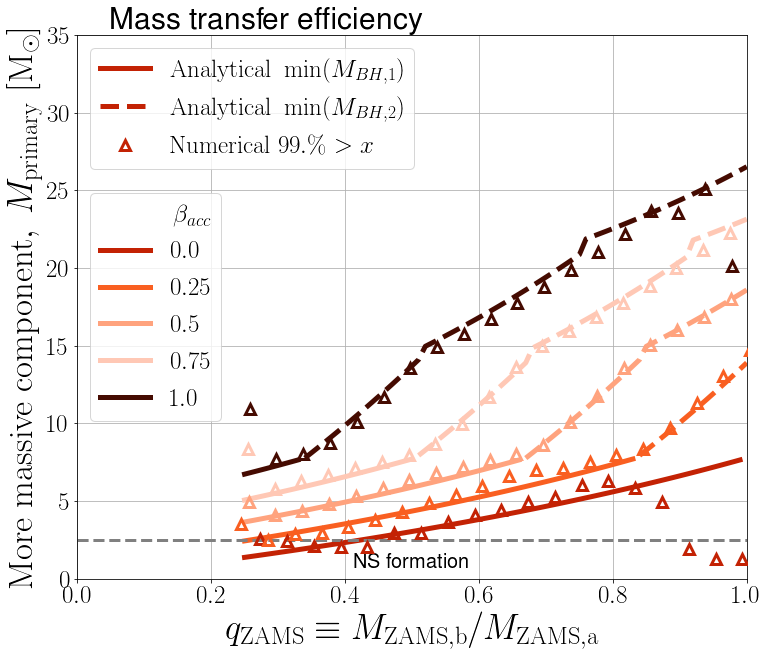

In [11]:

importlib.reload(mfunc)


##########################
# Define the variables
##########################
qzams     = np.arange(0.25,1.01, 0.01)
use_zeta  = False
zeta      = 6.0
print(mfunc.get_qcrit_from_zeta(Beta = 0.5, Zeta_eff = zeta))
qcrit2    = 4.32 #4.575 for zeta = 6.5,  4.06 for zet = 5.5



use_dMsn  = True
A_sn      = -0.9
B_sn      = 13.9
M_threshold = 14.8

#For quadratic function
# A_sn      = -0.1
# B_sn      = 1.5
# C_sn      = -2.14 

Fc1 = 0.34

beta_list = [0.0, 0.25,0.5, 0.75, 1.0]

# Simnames
simnames = ['faccFIXEDbeta%szetaHG6.0RemMassFRYER2012SNDELAYED/'%(BETA) for BETA in beta_list]

##########################
# Get minimum Mbh1,2 and ZAMS
##########################
MBH1_list, MBH2_list, MZAMS_list = [],[],[]

for  BETA in beta_list:
    # Mbh1
    Min_MBH1, qcrits = mfunc.get_analyticalMBH1(use_zeta = use_zeta, zeta = zeta, qcrit1 = qzams, qcrit2 = qcrit2, 
                                                Fc1 = Fc1, M_threshold = M_threshold,Beta = BETA, verbose = False,
                                                use_dMsn = use_dMsn, A_sn = A_sn, B_sn = B_sn)
    MBH1_list.append(Min_MBH1)

    # Mbh2
    minM_BH2 = mfunc.get_analyticalMBH2(minM_BH1 = Min_MBH1, qcrits = qcrits, Fc2 = Fc1)
    MBH2_list.append(minM_BH2)

    # Mzams1
    Minzams1 = mfunc.minMzams1_dMsn(qzams, qcrit2 = qcrits[:,1], beta = BETA, fc1 = Fc1, asn = A_sn, bsn= B_sn)
#     Minzams1 = mfunc.minMzams1_dMsn_quadratic(qzams, qcrit2 = qcrits[:,1], beta = BETA, fc1 = Fc1, asn = A_sn, bsn= B_sn, csn= C_sn)
    
    MZAMS_list.append(Minzams1)

    
    
##########################
# plot it
##########################
plot_MZAMS_QZAMS(qzams, MBH1_list, MBH2_list, MZAMS_list, simnames,
                 scatter_compas = False, percentile_compas = True, simdir = proj_dir+'/v02.26.03/N1e7Grid_BBH_BHNS_optimized/',
                 var_name = r'$\beta_{acc}$', var_list = ['$%s$'%(np.round(b,2)) for b in beta_list],
                 x_key = 'q_ZAMS', y_key = 'M_moreMassive', title_text = 'Mass transfer efficiency',
                 y_lim = (0.,35.), colors  = ['#c32204', '#f95f21','#ffa37e','#ffc8b5', '#450b01'], #oranges
                 save_name = 'ValidationPlot_beta_HR.pdf',title_string='$\mathrm{Mass \ dependent \ SN mass \ loss}$') #ValidationPlot_betas

    

# Zeta (or qcrit) variations

Zeta_eff is not a float
using method A, fc = const, dMsn(M)
using predefined MBH1 and qcrits
using method A, fc = const, dMsn(M)
using predefined MBH1 and qcrits
using method A, fc = const, dMsn(M)
using predefined MBH1 and qcrits
using method A, fc = const, dMsn(M)
using predefined MBH1 and qcrits
using method A, fc = const, dMsn(M)
using predefined MBH1 and qcrits
0
reading in  faccFIXEDbeta0.5zetaHG3.5RemMassFRYER2012SNDELAYED/
percentile failed, too little data in bin:  0 0
percentile failed, too little data in bin:  2 3.148134366866505
percentile failed, too little data in bin:  0 0
percentile failed, too little data in bin:  2 6.230529595015577
percentile failed, too little data in bin:  4 12.461059190031154
percentile failed, too little data in bin:  5 15.576323987538606
percentile failed, too little data in bin:  16 4.869694136241918
percentile failed, too little data in bin:  3 0.04733527947450923
1
reading in  faccFIXEDbeta0.5zetaHG4.5RemMassFRYER2012SNDELAYED/
percentile fai

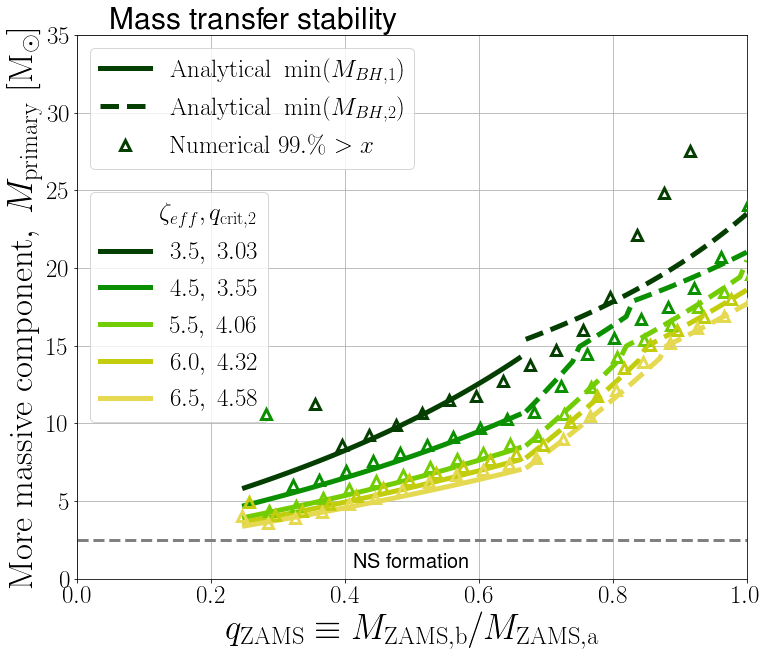

In [12]:
##########################
# Define the variables
##########################
qzams       = np.arange(0.25,1.01, 0.01)
use_zeta    = False
zeta_list   = [3.5, 4.5, 5.5, 6.0, 6.5]

q_crits     = mfunc.get_qcrit_from_zeta(Beta = 0.5, Zeta_eff = zeta_list)
qcrit2_list = q_crits[:,1]

use_dMsn  = True
A_sn      = -0.9
B_sn      = 13.9
M_threshold = 14.8

Fc1 = 0.34

beta = 0.5

# Simnames
simnames = ['faccFIXEDbeta0.5zetaHG%sRemMassFRYER2012SNDELAYED/'%(ZETA) for ZETA in zeta_list]

##########################
# Get minimum Mbh1,2 and ZAMS
##########################
MBH1_list, MBH2_list, MZAMS_list = [],[],[]

for qi, qcrit2 in enumerate(qcrit2_list):
    # Mbh1
    Min_MBH1, qcrits = mfunc.get_analyticalMBH1(use_zeta = use_zeta, zeta = zeta_list[qi], qcrit1 = qzams, qcrit2 = qcrit2, 
                                                Fc1 = Fc1, M_threshold = M_threshold,Beta = beta, verbose = False,
                                                use_dMsn = use_dMsn, A_sn = A_sn, B_sn = B_sn)
    MBH1_list.append(Min_MBH1)

    # Mbh2
    minM_BH2 = mfunc.get_analyticalMBH2(minM_BH1 = Min_MBH1, qcrits = qcrits, Fc2 = Fc1)
    MBH2_list.append(minM_BH2)

    # Mzams1
    Minzams1 = mfunc.minMzams1_dMsn(qzams, qcrit2 = qcrits[:,1], beta = beta, fc1 = Fc1, asn = A_sn, bsn= B_sn)
    MZAMS_list.append(Minzams1)

    
##########################
# plot it
##########################
plot_MZAMS_QZAMS(qzams, MBH1_list, MBH2_list, MZAMS_list, simnames, simdir = proj_dir+'/v02.26.03/N1e7Grid_BBH_BHNS_optimized/',
                 scatter_compas = False, percentile_compas = True,
                 var_name = r'$\zeta_{eff}, q_{\rm crit,2}$', var_list = ['$%s, \ %s$'%( np.round(zeta_list[i],2), np.round(qcrit2_list[i],2) ) for i in range(len(qcrit2_list)) ],
                 x_key = 'q_ZAMS', y_key = 'M_moreMassive', title_text = 'Mass transfer stability',
                 y_lim = (0.,35.), colors = ['#043e00','#098f00', '#72cd05', '#c1cd0d', '#e6d952'], #greens
                 save_name = 'ValidationPlot_Qcrit2_HR.pdf',title_string='$\mathrm{Mass \ dependent \ SN mass \ loss}$')



# Angular momentum (gamma) variations

both beta and zeta are floats
[[0.25383187 4.32045189]]
using method A, fc = const, dMsn(M)
using predefined MBH1 and qcrits
using method A, fc = const, dMsn(M)
using predefined MBH1 and qcrits
using method A, fc = const, dMsn(M)
using predefined MBH1 and qcrits
using method A, fc = const, dMsn(M)
using predefined MBH1 and qcrits
using method A, fc = const, dMsn(M)
using predefined MBH1 and qcrits
0
reading in  faccFIXEDbeta0.5gammaMIXTUREfcircum0.75zetaHG6.0RemMassFRYER2012SNDELAYED
percentile failed, too little data in bin:  0 0
percentile failed, too little data in bin:  5 0.3190051908929953
percentile failed, too little data in bin:  13 0.6454577479993884
percentile failed, too little data in bin:  20 0.5856071140570316
1
reading in  faccFIXEDbeta0.5gammaMIXTUREfcircum0.5zetaHG6.0RemMassFRYER2012SNDELAYED
percentile failed, too little data in bin:  0 0
percentile failed, too little data in bin:  8 4.498729714543397
percentile failed, too little data in bin:  11 0.38710929787153037


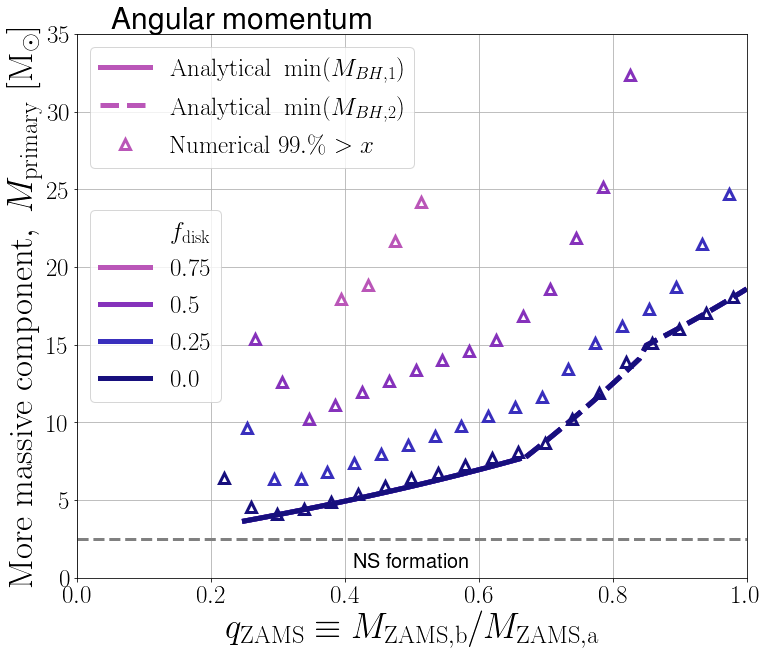

In [10]:
''' 
I don't have an analytical prescription for this at all... 
So what I'm gonna do is just repeat the fiducial 5 times, just to plot something.. :d 
'''

##########################
# Define the variables
##########################
qzams     = np.arange(0.25,1.01, 0.01)
use_zeta  = False
zeta      = 6.0
print(mfunc.get_qcrit_from_zeta(Beta = 0.5, Zeta_eff = zeta))
qcrit2    = 4.32 #4.575 for zeta = 6.5,  4.06 for zet = 5.5
use_dMsn  = True
A_sn      = -0.9
B_sn      = 13.9
M_threshold = 14.8
Fc1 = 0.34

beta_list = [0.5,0.5,0.5,0.5,0.5]

##########################
# Get minimum Mbh1,2 and ZAMS
##########################
MBH1_list, MBH2_list, MZAMS_list = [],[],[]

for  BETA in beta_list:
    # Mbh1
    Min_MBH1, qcrits = mfunc.get_analyticalMBH1(use_zeta = use_zeta, zeta = zeta, qcrit1 = qzams, qcrit2 = qcrit2, 
                                                Fc1 = Fc1, M_threshold = M_threshold,Beta = BETA, verbose = False,
                                                use_dMsn = use_dMsn, A_sn = A_sn, B_sn = B_sn)
    MBH1_list.append(Min_MBH1)

    # Mbh2
    minM_BH2 = mfunc.get_analyticalMBH2(minM_BH1 = Min_MBH1, qcrits = qcrits, Fc2 = Fc1)
    MBH2_list.append(minM_BH2)

    # Mzams1
    Minzams1 = mfunc.minMzams1_dMsn(qzams, qcrit2 = qcrits[:,1], beta = BETA, fc1 = Fc1, asn = A_sn, bsn= B_sn)
    MZAMS_list.append(Minzams1)


# f_cir 0 means NOTHING in circumbinary disk, everything in isotropic reemission
# f_cir 1 means EVERYTHING in circumbinary disk
fcircum_list = [0.75, 0.5, 0.25, 0.0 ]# , 1.0] all in circum is basically empty
simnames = ['faccFIXEDbeta0.5gammaMIXTUREfcircum%szetaHG6.0RemMassFRYER2012SNDELAYED'%(fcirc) for fcirc in fcircum_list ]

            
##########################
# plot it
##########################
plot_MZAMS_QZAMS(qzams, MBH1_list, MBH2_list, MZAMS_list, simnames,simdir = proj_dir+'/v02.26.03/N1e7Grid_BBH_BHNS_optimized/',
                scatter_compas = False, percentile_compas = True, show_analytical_sol = True,              
                var_name = r'$f_{\mathrm{disk} }$', var_list = ['$%s$'%(fcirc ) for fcirc in fcircum_list ], #['('+str(SN[0]) + ' , '+ str(SN[1])+')'  for SN in SN_variations],
                x_key = 'q_ZAMS', y_key = 'M_moreMassive', title_text = 'Angular momentum', 
                y_lim = (0.,35.), colors = ['#ba56b8', '#8632bb','#392fbd', '#170f7d'   ], #Purple-pink '#d787bd',=1.0
                save_name = 'ValidationPlot_gamma_faccFIXED_HR.pdf',title_string='$\mathrm{Mass \ dependent \ SN mass \ loss}$')

#blue colors colors = ['#051126', '#4c3f77', '#7c587f', '#a4bcbc', '#579fab', '#2680a6', '#005a8a']


# dMsn variations

both beta and zeta are floats
using method A, fc = const, dMsn(M)
using predefined MBH1 and qcrits
using method A, fc = const, dMsn(M)
using predefined MBH1 and qcrits
using method A, fc = const, dMsn(M)
using predefined MBH1 and qcrits
using method A, fc = const, dMsn(M)
using predefined MBH1 and qcrits
0
reading in  faccFIXEDbeta0.5zetaHG5.5RemMassFRYER2022fmix0.5SNDELAYED
percentile failed, too little data in bin:  0 0
percentile failed, too little data in bin:  5 2.0342494439720062
percentile failed, too little data in bin:  1 0.06634791649744837
percentile failed, too little data in bin:  1 1.2008155248816854
1
reading in  faccFIXEDbeta0.5zetaHG5.5RemMassFRYER2022fmix1.0SNDELAYED
percentile failed, too little data in bin:  0 0
percentile failed, too little data in bin:  1 2.2222222222222223
2
reading in  faccFIXEDbeta0.5zetaHG5.5RemMassFRYER2022fmix2.0SNDELAYED
percentile failed, too little data in bin:  0 0
percentile failed, too little data in bin:  2 2.4078640548244996
percenti

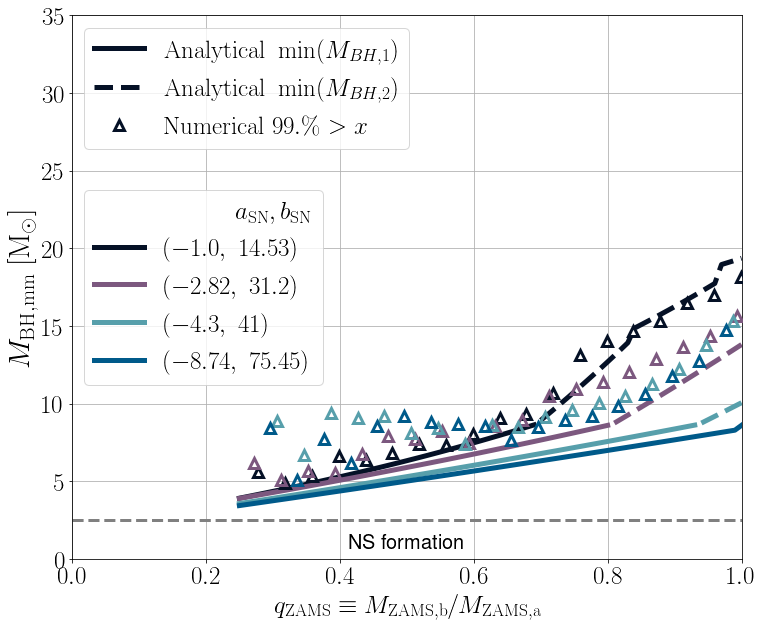

In [20]:
##########################
# Define the variables
##########################
qzams       = np.arange(0.25,1.01, 0.01)
zeta        = 5.5
q_crits     = mfunc.get_qcrit_from_zeta(Beta = 0.5, Zeta_eff = zeta)
qcrit2      = 4.06
use_zeta    = False

use_dMsn          = True
# [[0., 1], [-0.45, 7], [-0.9,13.9], [-1.5, 23], [-3, 46]]
# SN_variations     = [[-1.,14.53], [-1.5, 19], [-2.82, 31.2], [-2.67, 27.14], [-4.3, 41], [-5.98, 53.86], [-8.74, 75.45]] 
SN_variations     = [[-1.,14.53], [-2.82, 31.2], [-4.3, 41], [-8.74, 75.45]] 
# M_thresholds      = [13.8, 12.5, 11, 10.1 , 9.5, 9.0, 8.6]
M_thresholds      = [13.8, 11,  9.5,  8.6]

# [13.8, 11., 10, 9]

Fc1 = 0.3375

beta = 0.5

# Simnames
# [0.5, 0.7, 1.0, 1.4, 2.0, 2.8, 4.0] 
simnames = ['faccFIXEDbeta0.5zetaHG5.5RemMassFRYER2022fmix%sSNDELAYED'%(fmix) for fmix in [0.5, 1.0, 2.0, 4.0] ]

##########################
# Get minimum Mbh1,2 and ZAMS
##########################
MBH1_list, MBH2_list, MZAMS_list = [],[],[]


for SNi, SNvars in enumerate(SN_variations):
    A_sn      = SNvars[0] #-0.9
    B_sn      = SNvars[1] #13.9

    # Mbh1
    Min_MBH1, qcrits = mfunc.get_analyticalMBH1(use_zeta = use_zeta, zeta = zeta, qcrit1 = qzams, qcrit2 = qcrit2, 
                                                Fc1 = Fc1, M_threshold = M_thresholds[SNi],Beta = beta, verbose = False,
                                                use_dMsn = use_dMsn, A_sn = A_sn, B_sn = B_sn, C_sn = 0.)
    MBH1_list.append(Min_MBH1)

    # Mbh2
    minM_BH2 = mfunc.get_analyticalMBH2(minM_BH1 = Min_MBH1, qcrits = qcrits, Fc2 = Fc1)
    MBH2_list.append(minM_BH2)

    # Mzams1
    Minzams1 = mfunc.minMzams1_dMsn(qzams, qcrit2 = qcrits[:,1], beta = beta, fc1 = Fc1, asn = A_sn, bsn= B_sn)
    MZAMS_list.append(Minzams1)

##########################
# plot it
##########################
plot_MZAMS_QZAMS(qzams, MBH1_list, MBH2_list, MZAMS_list, simnames, simdir = proj_dir+'/v02.26.03/N1e6Grid_BBH_BHNS_optimized/',
                scatter_compas = False, percentile_compas = True,                 
                var_name = r'$a_{\rm SN}, b_{\rm SN}$', var_list = ['$(%s, \ %s)$'%( np.round(SN[0],2), np.round(SN[1],2) ) for SN in SN_variations ], #['('+str(SN[0]) + ' , '+ str(SN[1])+')'  for SN in SN_variations],
                x_key = 'q_ZAMS', y_key = 'M_moreMassive', ylabel= r'$M_{\mathrm{BH, mm}} \ \rm [M_{\odot}]$', 
                y_lim = (0.,35.), colors = ['#051126', '#7c587f', '#579fab', '#005a8a'], 
                save_name = 'ValidationPlot_dMsn.pdf',title_string='$\mathrm{Mass \ dependent \ SN mass \ loss}$')

#blue colors colors = ['#051126', '#4c3f77', '#7c587f', '#a4bcbc', '#579fab', '#2680a6', '#005a8a']


# fiducial for presentation purpose

Zeta_eff is not a float
using method A, fc = const, dMsn(M)
using predefined MBH1 and qcrits
0
reading in  faccFIXEDbeta0.5zetaHG6.0RemMassFRYER2012SNDELAYED/
percentile failed, probably bin is empty:  0
percentile failed, probably bin is empty:  5


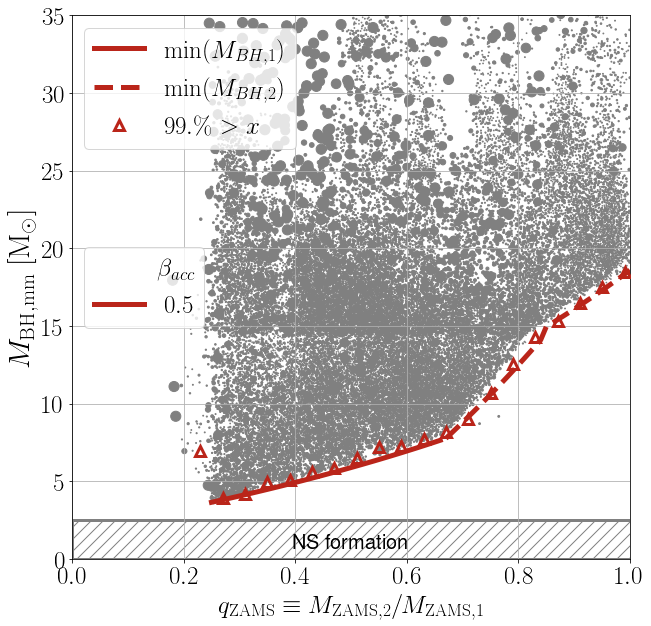

In [27]:
##########################
# Define the variables
##########################
qzams       = np.arange(0.25,1.01, 0.01)
use_zeta    = False
zeta_list   = [6.0]

q_crits     = mfunc.get_qcrit_from_zeta(Beta = 0.5, Zeta_eff = zeta_list)
qcrit2_list = q_crits[:,1]

use_dMsn  = True
A_sn      = -0.9
B_sn      = 13.9
M_threshold = 14.8

Fc1 = 0.34

beta_list = [0.5]

# Simnames
simnames = ['faccFIXEDbeta0.5zetaHG%sRemMassFRYER2012SNDELAYED/'%(ZETA) for ZETA in zeta_list]

##########################
# Get minimum Mbh1,2 and ZAMS
##########################
MBH1_list, MBH2_list, MZAMS_list = [],[],[]

for qi, qcrit2 in enumerate(qcrit2_list):
    # Mbh1
    Min_MBH1, qcrits = mfunc.get_analyticalMBH1(use_zeta = use_zeta, zeta = zeta_list[qi], qcrit1 = qzams, qcrit2 = qcrit2, 
                                                Fc1 = Fc1, M_threshold = M_threshold,Beta = beta, verbose = False,
                                                use_dMsn = use_dMsn, A_sn = A_sn, B_sn = B_sn)
    MBH1_list.append(Min_MBH1)

    # Mbh2
    minM_BH2 = mfunc.get_analyticalMBH2(minM_BH1 = Min_MBH1, qcrits = qcrits, Fc2 = Fc1)
    MBH2_list.append(minM_BH2)

    # Mzams1
    Minzams1 = mfunc.minMzams1_dMsn(qzams, qcrit2 = qcrits[:,1], beta = BETA, fc1 = Fc1, asn = A_sn, bsn= B_sn)
    MZAMS_list.append(Minzams1)

    
##########################
# plot it
##########################
plot_MZAMS_QZAMS(qzams, MBH1_list, MBH2_list, MZAMS_list, simnames,
                 scatter_compas = True, percentile_compas = True, show_analytical_sol = True,
                 var_name = r'$\beta_{acc}$', var_list = beta_list,
                 x_key = 'q_ZAMS', y_key = 'M_moreMassive', ylabel= r'$M_{\mathrm{BH, mm}} \ \rm [M_{\odot}]$', 
                 y_lim = (0.,35.), colors = ['#ba251a'], 
                 save_name = 'FiducialPlot_MmmQzams2.pdf', 
                 title_string='$\mathrm{Mass \ dependent \ SN mass \ loss}$')



***
***

# Method (B) fcore = f(M), dMsn = 0

***
***


In [8]:
import MinimumMassFunctions as mfunc
import importlib
importlib.reload(mfunc)

<module 'MinimumMassFunctions' from '/n/home04/lvanson/LowMBH_peak/Code/MinimumMassFunctions.py'>

both beta and zeta are floats
qcrit2_list [4.06444306]
MZAMS_list [-0.06967389  7.52475219 15.11917828 22.71360437 30.30803046 37.90245655
 45.49688264 53.09130872]
MBH1_list [0.24681885 0.26656436 0.28630986 0.30605537 0.32580088 0.34554639
 0.36529189 0.3850374 ]
MBH2_list [0.24960827 0.24981693 0.25002559 0.25023426 0.25044292 0.25065158
 0.25086024 0.2510689 ]
0
qzams, Min_MBH1 [0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95] [0.24681885 0.26656436 0.28630986 0.30605537 0.32580088 0.34554639
 0.36529189 0.3850374 ]
reading in  faccFIXEDbeta0.5zetaHG5.5RemMassMULLERMANDELBHkickZERO
LEN  72786


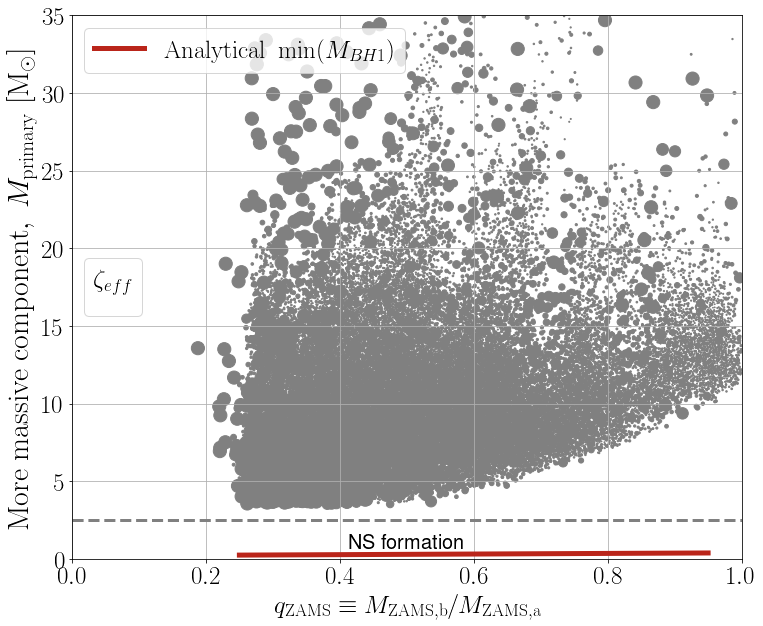

In [25]:
##########################
# Define the variables
##########################
qzams       = np.arange(0.25,1.01, 0.1)

use_zeta    = False # We pre calculate qcrit1 and 2 here, so no need to calculate it again
zeta       = 5.5
q_crits     = mfunc.get_qcrit_from_zeta(Beta = 0.5, Zeta_eff = zeta)
qcrit2_list = q_crits[:,1]
print('qcrit2_list', qcrit2_list)

use_dMsn  = False  # False means we are using  method (B) where fcore(Mzams) !!!
# Fit parameters for the function f_core(Mzams)
A_f       = 0.0026
B_f       = 0.247

beta = 1.

M_threshold = 0 # Always have 'full fallback'

##########################
# Get minimum Mbh1,2 and ZAMS
##########################
MBH1_list, MBH2_list, MZAMS_list = [],[],[]

# # Mbh1
# Min_MBH1, qcrits = mfunc.get_analyticalMBH1(use_zeta = use_zeta, zeta = zeta, qcrit1 = qzams, qcrit2 = qcrit2_list[0], 
#                                             M_threshold = 0,Beta = beta, verbose = True, use_dMsn = False, A_f = A_f, B_f = B_f)
# MBH1_list.append(Min_MBH1)

# # Mbh2
# minM_BH2 = mfunc.get_analyticalMBH2(minM_BH1 = Min_MBH1, qcrits = qcrits, use_dMsn = False)
# MBH2_list.append(minM_BH2)

# # Mzams1
# Minzams1 = mfunc.minMzams1_fcore(qzams, qcrit2 = qcrits[:,1], beta = beta, a_f = A_f, b_f= B_f )
# MZAMS_list.append(Minzams1)

MZAMS_list = 1./A_f  * ( (qzams + beta)/(qcrit2_list + beta) - B_f )

def M_core(Mzams, A_f = 0.0026, B_f= 0.247):
    fcore_Mdep =  A_f * Mzams + B_f
    M_core = fcore_Mdep * Mzams
    return fcore_Mdep

MBH1_list = M_core(MZAMS_list)

MpostMT1 = qcrit2_list * MBH1_list
MBH2_list = M_core(MpostMT1)


print('MZAMS_list', MZAMS_list)
print('MBH1_list', MBH1_list)
print('MBH2_list', MBH2_list)

# Simnames
simnames = ['faccFIXEDbeta0.5zetaHG5.5RemMassMULLERMANDELBHkickZERO']
#             faccFIXEDbeta0.5zetaHG6.5RemMassMULLERMANDELBHkickZERO'] #%(ZETA) for ZETA in zeta_list


# ##########################
# # plot it
# ##########################
plot_MZAMS_QZAMS(qzams, [MBH1_list], [MBH2_list], [MZAMS_list], simnames,y_key = 'Mass(1)',
                 scatter_compas = True, percentile_compas = False, show_analytical_sol = True,
                 var_name = r'$\zeta_{eff}$', var_list = [zeta],
                 y_lim = (0.,35.), colors = ['#ba251a'], 
                 save_name = 'test_methodB.pdf', title_string='$\mathrm{Mass \ dependent \ SN mass \ loss}$')



# plot_MZAMS_QZAMS(MBH1_list, MBH2_list, MZAMS_list, simnames,y_key = 'Mass(2)',
#                  scatter_compas = True, percentile_compas = False, show_analytical_sol = True,
#                  var_name = r'$\zeta_{eff}$', var_list = [zeta],
#                  y_lim = (0.,35.), colors = ['#ba251a'], 
#                  save_name = 'test_methodB.pdf', title_string='$\mathrm{Mass \ dependent \ SN mass \ loss}$')



In [36]:
simname    = 'faccFIXEDbeta0.5zetaHG6.5RemMassMULLERMANDELBHkickZERO'
proj_dir+'/v02.26.03/N1e6Grid_BBH_BHNS_optimized/'+ simname+ '/output/COMPAS_Output_wWeights.h5'


'/n/holystore01/LABS/hernquist_lab/Users/lvanson/CompasOutput//v02.26.03/N1e6Grid_BBH_BHNS_optimized/faccFIXEDbeta0.5zetaHG6.5RemMassMULLERMANDELBHkickZERO/output/COMPAS_Output_wWeights.h5'

In [48]:
##############################
# minimum M_ZAMS(1) through method A
##############################
def minMzams1_fcore(Q_ZAMS, qcrit2 = 4.6, beta = 1.0, a_f = 0.0026, b_f= 0.247 ):
    """
    Method B: assuming f_core is a function of M_zams
    Q_ZAMS     ----------> [(list of) floats] zams mass ratios M_2/M_1
    qcrit2     ----------> [float] stability mass ratio Q_{<mt2} = M_2/MBH < qcrit2
    beta       ----------> [float] the mas accretion fraction M_acc = beta M_don
    a_f,b_f    ----------> [float] fit parameters for f_core = a_f*M_tams + b_f 
    """
#     minMzams = 1./a_f * ( (Q_ZAMS + beta)/(qcrit2 + beta) -b_f )
    minMzams = 1./a_f * ( (Q_ZAMS + beta - b_f*(qcrit2 + beta) ) /(qcrit2 + beta) )

    return minMzams

    

q_zamses [0.         0.02040816 0.04081633 0.06122449 0.08163265 0.10204082
 0.12244898 0.14285714 0.16326531 0.18367347 0.20408163 0.2244898
 0.24489796 0.26530612 0.28571429 0.30612245 0.32653061 0.34693878
 0.36734694 0.3877551  0.40816327 0.42857143 0.44897959 0.46938776
 0.48979592 0.51020408 0.53061224 0.55102041 0.57142857 0.59183673
 0.6122449  0.63265306 0.65306122 0.67346939 0.69387755 0.71428571
 0.73469388 0.75510204 0.7755102  0.79591837 0.81632653 0.83673469
 0.85714286 0.87755102 0.89795918 0.91836735 0.93877551 0.95918367
 0.97959184 1.        ]
MinMzamsa [-57.29260935 -55.75353218 -54.21445501 -52.67537784 -51.13630067
 -49.5972235  -48.05814634 -46.51906917 -44.979992   -43.44091483
 -41.90183766 -40.36276049 -38.82368332 -37.28460615 -35.74552898
 -34.20645181 -32.66737464 -31.12829747 -29.5892203  -28.05014313
 -26.51106596 -24.9719888  -23.43291163 -21.89383446 -20.35475729
 -18.81568012 -17.27660295 -15.73752578 -14.19844861 -12.65937144
 -11.12029427  -9.5812171 

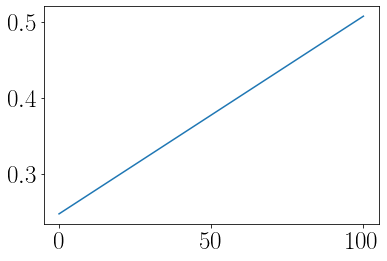

In [55]:
q_zamses = np.linspace(0,1,num=50)
print('q_zamses',q_zamses)

MinMzamsa = minMzams1_fcore(q_zamses, qcrit2 = 4.6, beta = 0.5, a_f = 0.0026, b_f= 0.247 )
print('MinMzamsa',MinMzamsa)

Mzams = np.linspace(0,100,num = 50)
plt.plot(Mzams, 0.0026*Mzams +0.247)
plt.show()



In [7]:

def plot_MZAMS_QZAMS_fcore(Final_DCO=None, y_key = 'Mass@ZAMS(1)', y_lim = (0.,150.), beta_list = [0.5],
                     use_zeta = False, zeta_list = [6.5], qcrit1 = np.arange(0.25,1.05, 0.05), qcrit2 = 4.575, 
                     Fc1 = 0.355, Fc2 = 0.375, M_threshold = 14.8, Beta = 1.0, 
                     use_dMsn = False, A_sn = -0.9, B_sn = 13.9, A_f = 0.0026, B_f = 0.247, 
                     scatter_compas = True,percentile_compas = True,
                     save_name = 'MinimumComparedToSim.png', ylabel = '$M_{\mathrm{remnant, \ more \ M}}$',
                     title_string='$\mathrm{Mass \ dependent \ SN mass \ loss}$'):

    ##########################
    fig,ax = plt.subplots(figsize = (10,10))

#     kleurmap = sns.color_palette("rainbow", as_cmap=True)#tab20
    colors = ['#051126', '#4c3f77', '#7c587f', '#a4bcbc', '#007f97']
    x_key = 'q_ZAMS'
    plot_lines = []
    
#     for i, zeta in enumerate(zeta_list):
#         simname    = 'faccTHERMALzetaHG%sRemMassMULLERMANDELBHkickZERO'%(zeta)#'faccFIXEDbeta0.5zetaHG%sRemMassMULLERMANDELBHkickZERO'%(zeta)
#         #'RemMassMULLERMANDELBHkickZERO'
#         BETA = beta_list[0]

    for i, BETA in enumerate(beta_list):
        simname    = 'faccFIXEDbeta%szetaHG3.5RemMassMULLERMANDELBHkickZERO'%(BETA)
        #'faccFIXEDbeta%szetaHG3.5RemMassFRYER2012SNDELAYED'%(BETA)#'faccFIXEDbeta%s'%(BETA)
        zeta = zeta_list[0]
    
        print('reading in ', simname)
        Rate_key      =  'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned'
        RLOF, SYS, DCO, DCO_mask, redshifts, Average_SF_mass_needed, intrinsic_rate_density, intrinsic_rate_density_z0, =\
            read_data(loc =  proj_dir+'/v02.26.03/N1e6Grid_BBH_BHNS_optimized/'+ simname+ '/output/COMPAS_Output_wWeights.h5', rate_key = Rate_key, verbose = False)
            #             N1e6Grid/
#         Final_DCO, merging_BH, DCO = get_only_stableDCO(File_location = proj_dir+'/v02.26.03/N1e6Grid/'+ simname +'/output/COMPAS_Output_wWeights.h5', 
#                                                     DCO_type = "BBH_BHNS")#BBH_only #BBH_BHNS

        Final_DCO = DCO
        ##########################
        # Filter out XX
        plot_table  = Final_DCO 
#         extra_bool  = plot_table['experiencedHGHG_MT'] == True
        extra_bool = plot_table['Merges_Hubble_Time']==True 
        no_NSNS     = np.invert(np.logical_and(plot_table['Stellar_Type(1)'] ==13, plot_table['Stellar_Type(2)'] == 13))
        stable_RLOF = plot_table['CE_Event_Counter'] == 0 #CE_Event_Counter
        # stable RLOF channel
        BBH_stablechannel     = plot_table[stable_RLOF *no_NSNS  * extra_bool]

    
        ##########################
        # COMPAS 
        ##########################
        if scatter_compas:
            plt.scatter(BBH_stablechannel[x_key], BBH_stablechannel[y_key],
                        s = 50* BBH_stablechannel['mixture_weight'], c = 'grey', label =None, marker = 'o')#    
        if percentile_compas:
            dx = 0.05
            x_bins, min_array = np.arange(min(BBH_stablechannel[x_key]),1.+dx,dx), []
            center_x = (x_bins[:-1] + x_bins[1:])/2. 

            # Bin the data
            BinnedIndices = np.digitize(BBH_stablechannel[x_key],  x_bins)
            for BIN in np.unique(BinnedIndices):
                bin_bool = BinnedIndices == BIN # grab systems in this bin
                # calculate where 97% is higher (1-percentile?)
                percentile = mfunc.weighted_percentile(data = BBH_stablechannel[y_key][bin_bool], 
                                                       weights = BBH_stablechannel['mixture_weight'][bin_bool], perc = 0.01)
                min_array.append(percentile)
            # Plot it
#             plt.scatter(center_x, min_array, c = 'none', edgecolor =colors[i],linewidths=2.5,
#                         label ='$97.\% > x$', marker = '^', s = 100, zorder = 10)

        ##########################
        # Plot analytical solutions
        ##########################
        #Calculate MBH1 and MBH2
        qzams  = qcrit1#np.arange(0.25,1.01, 0.01)

        Min_MBH1, qcrits = mfunc.get_analyticalMBH1(use_zeta = use_zeta, zeta = zeta, qcrit1 = qzams, qcrit2 = qcrit2, 
                                                    Fc1 = Fc1, M_threshold = M_threshold, Beta = BETA, verbose = False,
                                                    use_dMsn = use_dMsn, A_sn = A_sn, B_sn = B_sn, A_f = A_f, B_f = B_f)
        minM_BH2 = mfunc.get_analyticalMBH2(minM_BH1 = Min_MBH1, qcrits = qcrits, Fc2 = Fc2, use_dMsn = use_dMsn)
        
        if y_key == 'Mass@ZAMS(1)':
            ########################
            # Using method (A): fc = const, and dMsn(fc*Mzams)
            if use_dMsn: 
                print('using method A, fc = const, dMsn(M)')
                Minzams1 = mfunc.minMzams1_dMsn(qzams, qcrit2 = qcrits[:,1], beta = BETA, fc1 = Fc1, asn = A_sn, bsn= B_sn)

            ########################
            # Using method (B): fc(Mzams1), and dMsn=0
            else:
                print('using method B, fc(M), dMsn = 0')
                Minzams1 = mfunc.minMzams1_fcore(qzams, qcrit2 = qcrits[:,1], beta = BETA, a_f = A_f, b_f = B_f)
                Fc1      = mfunc.fcore(Minzams1,  a_f = A_f, b_f= B_f)

                
            plot_lines.append(plt.plot(qzams, Minzams1, c = 'r', ls = '--', lw = 5, label = '$\min(M_{zams1})$ stable MT2'))

        ##########################
        if y_key == 'Mass(1)':
            plt.plot(qzams, Min_MBH1, c = 'dodgerblue', ls = '--', lw = 5, label = '$\min(M_{BH1})$')

        ##########################        
        if y_key == 'Mass(2)':
            plt.plot(qzams, minM_BH2, c = 'darkorange', ls = '--', lw = 5, label = '$\min(M_{BH2})$ ')

        if y_key =='M_moreMassive':
            #min_MBHmoremass = np.maximum(Min_MBH1, minM_BH2)
            M1_morethan_M2 = Min_MBH1 >= minM_BH2
            plot_lines.append(plt.plot(qzams[M1_morethan_M2], Min_MBH1[M1_morethan_M2], c = colors[i], ls = '-', lw = 5, label = '$\min(M_{BH,1})$ '))
            plt.plot(qzams[np.invert(M1_morethan_M2)], minM_BH2[np.invert(M1_morethan_M2)], c = colors[i], ls = '--', lw = 5, label = '$\min(M_{BH,2})$ ')

        ########################## 
        # Plot first legend
        if i ==0:
            legend1 = plt.legend(loc = 'upper left')
            
    ##########################        
    # NS boundary
    plt.axhline(y = 2.5, lw = 3, color = 'grey', ls = '--')
    ax.text(0.6, 2, 'NS', fontsize = 15, va = 'top', color = 'grey', clip_on = True)
         
    plt.plot(np.arange(0,50), np.arange(0,50), ls = '--', c = 'grey', clip_on = True)

    #####
    # add legend
#     plt.legend([l[0] for l in plot_lines], ['$%s$'%(z) for z in zeta_list ], 
#                title = r'$\zeta_{eff}$', loc = 'center left')
    plt.legend([l[0] for l in plot_lines], ['$%s$'%(b) for b in beta_list ], 
               title = r'$\beta_{acc}$', loc = 'center left')
    plt.gca().add_artist(legend1)
    
    ##########################
    # Plotvalues 
    plt.xlabel('$q_{\mathrm{ZAMS}} \equiv M_{\mathrm{ZAMS,2}}/M_{\mathrm{ZAMS,1}} $')#x_key.replace('_', ' '))
    plt.ylabel(ylabel, size =30)#y_key.replace('_', ' '))

    plt.grid()
#     plt.legend(loc = 'upper right')
    plt.xlim(0.,1.)
    plt.ylim(y_lim)
    plt.title(title_string)
#     plt.title(simname.replace('_', ' '))
    plt.savefig(save_loc + save_name)
    plt.show()




# Full fallback (MullerMandel) remnant mass prescription, $\beta$ variations ($\zeta = 3.5$)

reading in  faccFIXEDbeta1.0zetaHG3.5RemMassMULLERMANDELBHkickZERO
using method B, fc(M), dMsn = 0
using predefined MBH1 and qcrits

 making fcore Fc2 [0.31260377 0.31531143 0.31805373 0.32083068 0.32364227 0.32648852
 0.32936941 0.33228495 0.33523514 0.33821997 0.34123946 0.34429359
 0.34738237 0.3505058  0.35366388 0.3568566  0.36008397 0.36334599
 0.36664266 0.36997398 0.37333994 0.37674055 0.38017581 0.38364572
 0.38715028 0.39068948 0.39426333 0.39787183 0.40151498 0.40519278
 0.40890522 0.41265231 0.41643405 0.42025044 0.42410147 0.42798716
 0.43190749 0.43586247 0.4398521  0.44387637 0.4479353  0.45202887
 0.45615709 0.46031996 0.46451747 0.46874963 0.47301645 0.4773179
 0.48165401 0.48602477 0.49043017 0.49487022 0.49934492 0.50385427
 0.50839826 0.51297691 0.5175902  0.52223814 0.52692072 0.53163796
 0.53638984 0.54117637 0.54599755 0.55085338 0.55574385 0.56066898
 0.56562875 0.57062317 0.57565223 0.58071595 0.58581431 0.59094732
 0.59611498 0.60131729 0.60655424 0.61182585]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


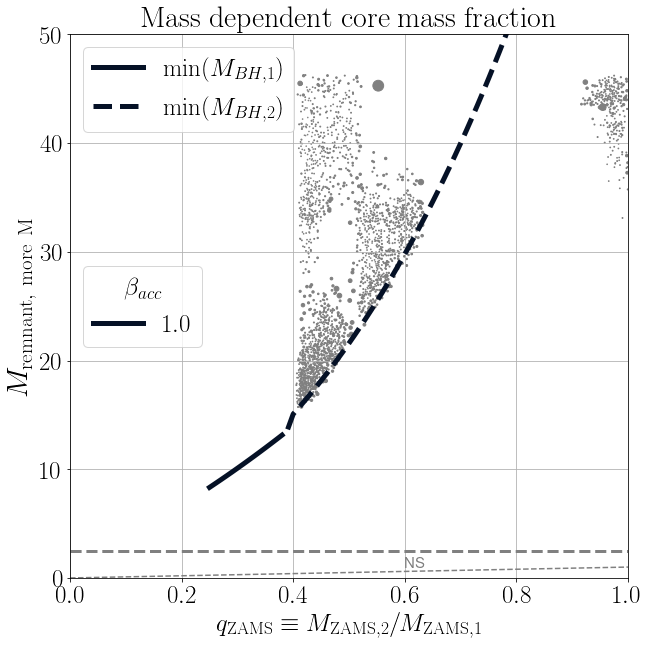

In [8]:
#######################
### Zeta = 3.5 --> qcrit reverse = 3.03
#######################
plot_MZAMS_QZAMS_fcore(y_key = 'M_moreMassive',  beta_list = [1.0], y_lim = (0, 50),  
                       qcrit1 = np.arange(0.25,1.01, 0.01), qcrit2 = 3.03, zeta_list = [3.5],
                       Fc1 = 0.353, Fc2 = 0.6, scatter_compas = True,
                       use_dMsn = False, A_sn = -0.9, B_sn = 13.9, A_f = 0.0028, B_f = 0.235, M_threshold = 0.,
                       save_name = 'MinimumComparedToSim_MmoreMass_fcore_zetaVar.png',
                       title_string=r'$\mathrm{Mass \ dependent \ core \ mass \ fraction}$')
